# Sistemas Inteligentes
## Maestría en Tecnologías de la Información
## Dr. José Antonio Orizaba Trejo
Fecha: 19 de Febrero 
Alumno: Anaid Trejo Huerta
Código de alumno: 304510062

## 1 Segmentación de usuarios (no supervisado) con Clustering y
# K-Means (Scikit-learn + Seaborn)
Caso de uso (pequeño):
Imagina una plataforma digital tipo marketplace (venta/renta) donde cada “usuario”
principal puede modelarse como un perfil de consumo asociado al tipo de vehículo
que consulta/compra (o al tipo de anuncio que publica).

La plataforma quiere personalizar recomendaciones, campañas y planes de fi-
nanciamiento pero no tiene etiquetas (no sabe quién es “premium”, “ahorrador”,
“deportivo”, etc.).

Solución: aplicar aprendizaje no supervisado para agrupar perfiles similares con
K-Means y así crear segmentos accionables.
En este cuaderno usamos el dataset adjunto Automobile_data.csv (205 registros, 26 variables)
como una representación proxy de perfiles (p. ej., patrones de preferencia/consumo).

El objetivo es descubrir segmentos de forma automática y describirlos con métricas interpreta-
bles.

1.1 1) Importaciones y configuración
Trabajaremos con: - pandas / numpy para manipulación de datos
- scikit-learn para preprocessing y K-Means
- seaborn / matplotlib para visualización

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

# Para reproducibilidad
RANDOM_STATE = 42
# Estilo visual
sns.set_theme(style="whitegrid")

1.2 2) Cargar el dataset
El archivo está en la misma carpeta del cuaderno 

In [8]:
# <- archivo adjunto
DATA_PATH = "Automobile_data.csv"
df = pd.read_csv(DATA_PATH)
print("Dimensiones:", df.shape)
df.head()

Dimensiones: (205, 26)


,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,...,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495
1,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500
2,1,?,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500
3,2,164,audi,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.4,10.0,102,5500,24,30,13950
4,2,164,audi,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.4,8.0,115,5500,18,22,17450


1.3 3) Exploración rápida
• Revisamos tipos de datos
• Detectamos valores faltantes (en este dataset aparecen como ?)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   symboling          205 non-null    int64  
 1   normalized-losses  205 non-null    object 
 2   make               205 non-null    object 
 3   fuel-type          205 non-null    object 
 4   aspiration         205 non-null    object 
 5   num-of-doors       205 non-null    object 
 6   body-style         205 non-null    object 
 7   drive-wheels       205 non-null    object 
 8   engine-location    205 non-null    object 
 9   wheel-base         205 non-null    float64
 10  length             205 non-null    float64
 11  width              205 non-null    float64
 12  height             205 non-null    float64
 13  curb-weight        205 non-null    int64  
 14  engine-type        205 non-null    object 
 15  num-of-cylinders   205 non-null    object 
 16  engine-size        205 non

In [10]:
# Conteo de valores "?" por columna (proxy de faltantes)
missing_q = (df == "?").sum().sort_values(ascending=False)
missing_q[missing_q > 0]

normalized-losses    41
price                 4
stroke                4
bore                  4
peak-rpm              2
num-of-doors          2
horsepower            2
dtype: int64

1.4 4) Limpieza y preparación
1.4.1 ¿Qué haremos?
1. Reemplazar ? por NaN
2. Convertir a numéricas las columnas que deberían ser numéricas
3. Elegir variables numéricas útiles para segmentar
4. Imputar valores faltantes (mediana)
5. Estandarizar variables (muy importante para K-Means)

In [13]:
df_clean = df.replace("?", np.nan).copy()
# Columnas que son numéricas (por dominio del dataset) pero vienen como texto por los '?'
numeric_cols_expected = [
    "normalized-losses", "wheel-base", "length", "width", "height",
    "curb-weight", "engine-size", "bore", "stroke", "compression-ratio",
    "horsepower", "peak-rpm", "city-mpg", "highway-mpg", "price"
]
for col in numeric_cols_expected:
    if col in df_clean.columns:
        df_clean[col] = pd.to_numeric(df_clean[col], errors="coerce")
df_clean[numeric_cols_expected].describe().T.head(10)

,count,mean,std,min,25%,50%,75%,max
normalized-losses,164.0,122.000000,35.442168,65.00,94.00,115.00,150.00,256.00
wheel-base,205.0,98.756585,6.021776,86.60,94.50,97.00,102.40,120.90
length,205.0,174.049268,12.337289,141.10,166.30,173.20,183.10,208.10
width,205.0,65.907805,2.145204,60.30,64.10,65.50,66.90,72.30
height,205.0,53.724878,2.443522,47.80,52.00,54.10,55.50,59.80
curb-weight,205.0,2555.565854,520.680204,1488.00,2145.00,2414.00,2935.00,4066.00
engine-size,205.0,126.907317,41.642693,61.00,97.00,120.00,141.00,326.00
bore,201.0,3.329751,0.273539,2.54,3.15,3.31,3.59,3.94
stroke,201.0,3.255423,0.316717,2.07,3.11,3.29,3.41,4.17
compression-ratio,205.0,10.142537,3.972040,7.00,8.60,9.00,9.40,23.00


1.4.2 Selección de variables para el clustering
Para una segmentación accionable, usamos variables que suelen correlacionar con: - desempeño
y potencia (engine-size, horsepower) - costo/segmento (price) - eficiencia (city-mpg, highway-mpg)
- tamaño/peso (curb-weight, length, width)
Nota: podríamos incluir variables categóricas (make, body-style, etc.), pero para un
caso pequeño y claro, empezamos con numéricas.

In [14]:
features = ["price", "engine-size", "horsepower", "city-mpg", "highway-mpg",
    "curb-weight", "length", "width"]

X = df_clean[features].copy()
X.head()

,price,engine-size,horsepower,city-mpg,highway-mpg,curb-weight,length,width
0,13495.0,130,111.0,21,27,2548,168.8,64.1
1,16500.0,130,111.0,21,27,2548,168.8,64.1
2,16500.0,152,154.0,19,26,2823,171.2,65.5
3,13950.0,109,102.0,24,30,2337,176.6,66.2
4,17450.0,136,115.0,18,22,2824,176.6,66.4


1.5 5) Pipeline de preprocessing
Creamos un pipeline para: - imputación por mediana - escalado estándar (media 0, varianza 1)
Esto evita fugas de datos y deja el proceso repetible.

In [15]:
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])
preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, features),
    ],
remainder="drop"
)
X_prepared = preprocess.fit_transform(X)
X_prepared.shape

(205, 8)

1.6 6) Elegir el número de clusters (k)
K-Means requiere definir k. Usaremos dos enfoques: 1. Elbow method (inercia)
2. Silhouette score (calidad de separación; más alto suele ser mejor)
Probamos k = 2..10 para quedarnos con un valor razonable.

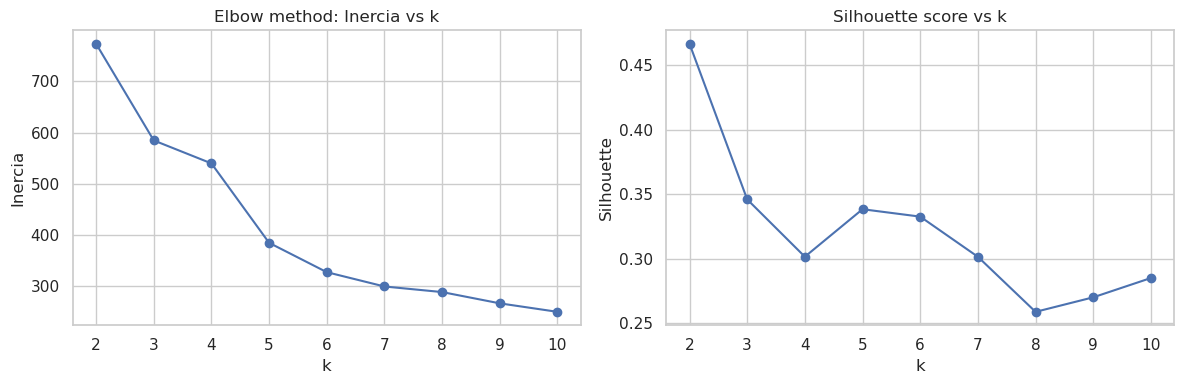

,k,inertia,silhouette
0,2,773.532827,0.466513
1,3,584.849076,0.345886
2,4,539.976665,0.301455
3,5,384.951972,0.338269
4,6,327.697345,0.332524
5,7,299.745061,0.301412
6,8,288.854592,0.258737
7,9,266.840978,0.270001
8,10,250.260773,0.284955


In [18]:
ks = range(2, 11)
inertias = []
sil_scores = []
for k in ks:
    km = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init="auto")
    labels = km.fit_predict(X_prepared)
    inertias.append(km.inertia_)
    sil_scores.append(silhouette_score(X_prepared, labels))
fig = plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(list(ks), inertias, marker="o")

plt.title("Elbow method: Inercia vs k")
plt.xlabel("k")
plt.ylabel("Inercia")
plt.subplot(1,2,2)
plt.plot(list(ks), sil_scores, marker="o")
plt.title("Silhouette score vs k")
plt.xlabel("k")
plt.ylabel("Silhouette")
plt.tight_layout()
plt.show()
pd.DataFrame({"k": list(ks), "inertia": inertias, "silhouette": sil_scores})

1.6.1 Decisión de k (regla práctica)
• El codo en la inercia sugiere un punto donde la mejora marginal baja.
• El silhouette ayuda a escoger un k con buena separación.
En este cuaderno tomaremos un k que: - tenga silhouette relativamente alto y - no sea excesivo
para interpretación (segmentación “usable”)
Ajusta K_SELECTED si tus gráficas indican otro valor.

In [19]:
# Ajusta este valor según tus gráficas:
K_SELECTED = 4
kmeans = KMeans(n_clusters=K_SELECTED, random_state=RANDOM_STATE, n_init="auto")
clusters = kmeans.fit_predict(X_prepared)
df_segmented = df_clean.copy()
df_segmented["cluster"] = clusters
df_segmented["cluster"].value_counts().sort_index()

cluster
0    17
1    64
2    75
3    49
Name: count, dtype: int64

1.7 7) Visualización de clusters (PCA 2D)
Como tenemos varias variables, reducimos a 2 componentes principales para visualizar en un plano.
> PCA aquí es SOLO para visualización, no para “mejorar” el clustering.

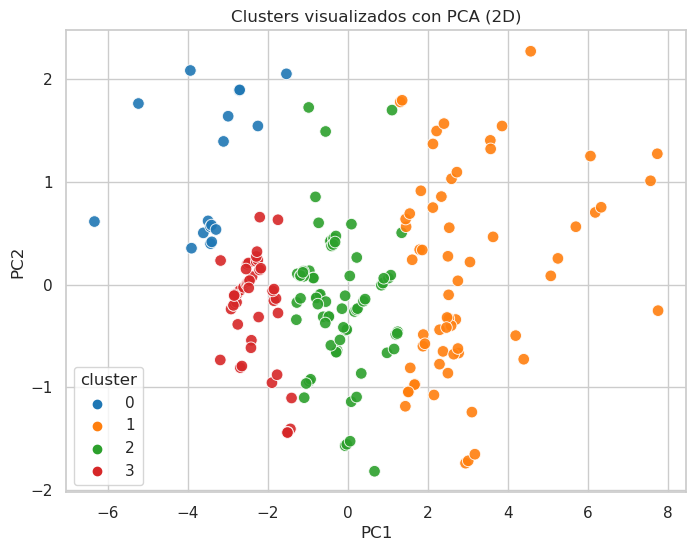

Varianza explicada por PCA: [0.78020936 0.08465012] => total: 0.8648594758925376


In [20]:
pca = PCA(n_components=2, random_state=RANDOM_STATE)
X_2d = pca.fit_transform(X_prepared)
viz = pd.DataFrame(X_2d, columns=["PC1", "PC2"])
viz["cluster"] = df_segmented["cluster"].astype(int)
plt.figure(figsize=(8,6))
sns.scatterplot(data=viz, x="PC1", y="PC2", hue="cluster", palette="tab10",s=70, alpha=0.9)
plt.title("Clusters visualizados con PCA (2D)")
plt.show()
print("Varianza explicada por PCA:", pca.explained_variance_ratio_, "=> total:", pca.explained_variance_ratio_.sum())

1.8 8) Interpretación: “perfil” promedio por cluster
Para que la segmentación sea útil, necesitamos traducir cada cluster a un perfil. Calculamos
promedios (y medianas) por cluster de nuestras variables clave.

In [21]:
profile_mean = df_segmented.groupby("cluster")[features].mean().round(2)
profile_median = df_segmented.groupby("cluster")[features].median().round(2)
display(profile_mean)
display(profile_median)

,price,engine-size,horsepower,city-mpg,highway-mpg,curb-weight,length,width
cluster,,,,,,,,
0,7007.80,93.41,62.76,39.12,44.94,1999.35,160.29,64.13
1,21793.00,170.17,147.17,19.06,23.94,3180.45,186.12,68.26
2,11344.05,117.93,98.03,24.32,30.16,2481.87,174.78,65.61
3,7092.78,95.76,71.88,29.82,35.63,2045.16,161.94,63.91


,price,engine-size,horsepower,city-mpg,highway-mpg,curb-weight,length,width
cluster,,,,,,,,
0,6575.0,92.0,68.0,38.0,43.0,1918.0,157.30,63.90
1,18150.0,156.0,148.5,19.0,24.0,3075.0,187.65,68.15
2,10295.0,120.0,97.0,24.0,30.0,2414.0,175.00,65.50
3,7126.0,97.0,69.0,31.0,37.0,2015.0,162.40,63.80


1.8.1 Etiquetado cualitativo (ejemplo)
Con base en los promedios/medianas, normalmente podemos describir segmentos como: -
Económicos/Eficientes: menor precio, mayor mpg
- Potentes/Deportivos: más horsepower/engine-size, menor mpg
- Intermedios/Balanceados: métricas moderadas
- Grandes/Pesados: mayor curb-weight y dimensiones
Estos nombres son “de negocio” y pueden cambiar según tu plataforma (renta, venta,
financiamiento, etc.).
1.9 9) Visualización por variables (Seaborn)
Un vistazo rápido a cómo se distribuyen algunas variables por cluster.

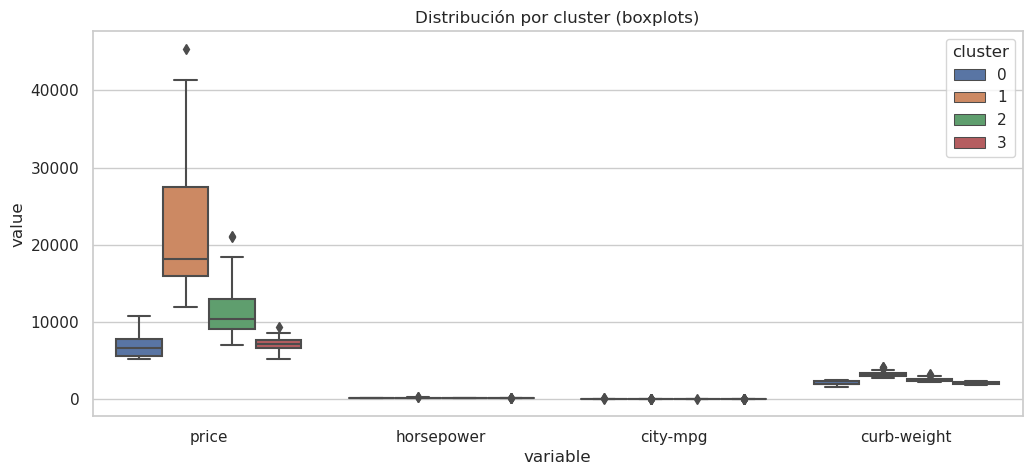

In [22]:
melt_cols = ["price", "horsepower", "city-mpg", "curb-weight"]
tmp = df_segmented[["cluster"] + melt_cols].melt(id_vars="cluster",var_name="variable", value_name="value")
plt.figure(figsize=(12,5))
sns.boxplot(data=tmp, x="variable", y="value", hue="cluster")
plt.title("Distribución por cluster (boxplots)")
plt.xticks(rotation=0)
plt.show()

1.10 10) Actividad práctica (para entregar / evidenciar aprendizaje)
1.10.1 Tu tarea
1. Cambia K_SELECTED a 3, 4, 5 y compara:
• silhouette score
• interpretabilidad de perfiles
2. Agrega 2 variables adicionales al clustering (elige de: height, wheel-base, peak-rpm,
compression-ratio)
3. Escribe una breve conclusión:
• ¿Qué k te parece más útil para negocio?
• ¿Qué segmento atacarías con una campaña “Ahorro de combustible”?
• ¿Qué segmento sería candidato a “Financiamiento premium”?

In [23]:
features = ["price", "engine-size", "horsepower", "city-mpg", "highway-mpg",
    "curb-weight", "length", "width","wheel-base","peak-rpm"]

X = df_clean[features].copy()
X.head()

,price,engine-size,horsepower,city-mpg,highway-mpg,curb-weight,length,width,wheel-base,peak-rpm
0,13495.0,130,111.0,21,27,2548,168.8,64.1,88.6,5000.0
1,16500.0,130,111.0,21,27,2548,168.8,64.1,88.6,5000.0
2,16500.0,152,154.0,19,26,2823,171.2,65.5,94.5,5000.0
3,13950.0,109,102.0,24,30,2337,176.6,66.2,99.8,5500.0
4,17450.0,136,115.0,18,22,2824,176.6,66.4,99.4,5500.0


In [26]:
# Ajusta este valor según tus gráficas:
K_SELECTED = 5
kmeans = KMeans(n_clusters=K_SELECTED, random_state=RANDOM_STATE, n_init="auto")
clusters = kmeans.fit_predict(X_prepared)
df_segmented = df_clean.copy()
df_segmented["cluster"] = clusters
df_segmented["cluster"].value_counts().sort_index()

cluster
0    16
1    18
2    68
3    45
4    58
Name: count, dtype: int64

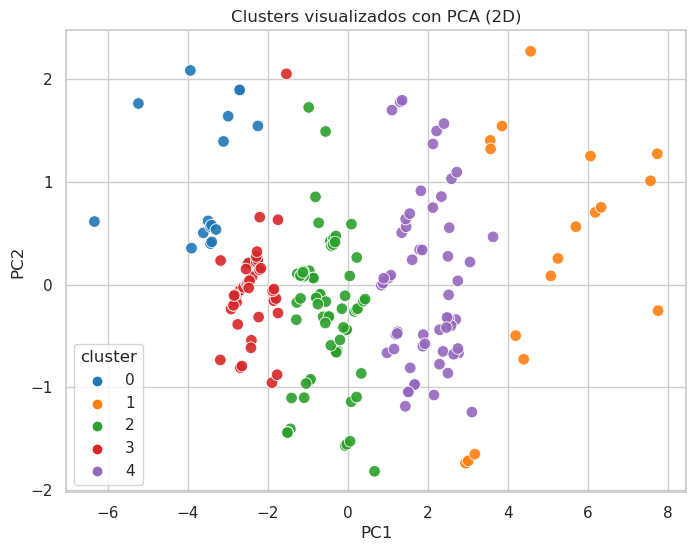

Varianza explicada por PCA: [0.78020936 0.08465012] => total: 0.8648594758925376


In [27]:
pca = PCA(n_components=2, random_state=RANDOM_STATE)
X_2d = pca.fit_transform(X_prepared)
viz = pd.DataFrame(X_2d, columns=["PC1", "PC2"])
viz["cluster"] = df_segmented["cluster"].astype(int)
plt.figure(figsize=(8,6))
sns.scatterplot(data=viz, x="PC1", y="PC2", hue="cluster", palette="tab10",s=70, alpha=0.9)
plt.title("Clusters visualizados con PCA (2D)")
plt.show()
print("Varianza explicada por PCA:", pca.explained_variance_ratio_, "=> total:", pca.explained_variance_ratio_.sum())

In [28]:
profile_mean = df_segmented.groupby("cluster")[features].mean().round(2)
profile_median = df_segmented.groupby("cluster")[features].median().round(2)
display(profile_mean)
display(profile_median)

,price,engine-size,horsepower,city-mpg,highway-mpg,curb-weight,length,width,wheel-base,peak-rpm
cluster,,,,,,,,,,
0,6737.29,91.62,62.69,39.31,45.12,1971.62,159.19,63.98,94.10,5106.25
1,34442.06,225.89,179.94,17.00,21.67,3524.72,189.73,69.52,105.52,5002.78
2,10330.46,113.01,95.38,24.79,30.53,2409.62,172.41,65.31,97.32,5179.55
3,7097.67,95.80,68.89,30.60,36.42,2038.38,162.51,64.02,94.44,5150.00
4,16718.07,146.34,129.78,20.21,25.47,2988.26,184.16,67.48,102.98,5087.93


,price,engine-size,horsepower,city-mpg,highway-mpg,curb-weight,length,width,wheel-base,peak-rpm
cluster,,,,,,,,,,
0,6527.0,91.0,68.0,38.0,43.0,1913.5,157.3,63.85,94.50,5250.0
1,34184.0,209.0,182.0,16.0,22.0,3600.0,191.3,70.30,108.35,4750.0
2,9927.0,110.0,92.0,24.5,30.5,2390.0,173.2,65.40,97.00,5100.0
3,7053.0,92.0,69.0,31.0,37.0,2008.0,165.3,63.80,94.50,5200.0
4,16558.0,141.0,121.0,19.0,25.0,3018.0,186.6,67.20,103.20,5200.0


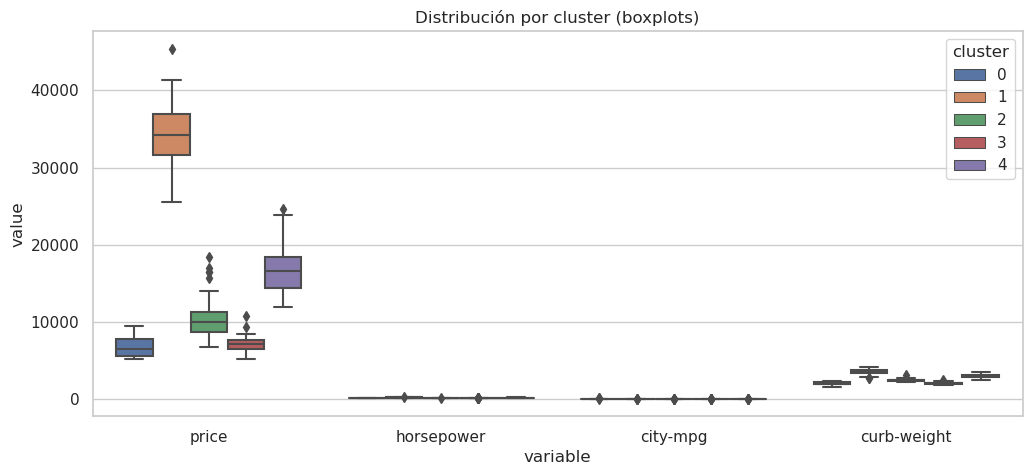

In [29]:
melt_cols = ["price", "horsepower", "city-mpg", "curb-weight"]
tmp = df_segmented[["cluster"] + melt_cols].melt(id_vars="cluster",var_name="variable", value_name="value")
plt.figure(figsize=(12,5))
sns.boxplot(data=tmp, x="variable", y="value", hue="cluster")
plt.title("Distribución por cluster (boxplots)")
plt.xticks(rotation=0)
plt.show()

## Conclusión

Al comparar los valores de silhouette score el valor más alto corresponde a k = 2 (0.466); aunque presenta mejor separación estadística, genera una segmentación demasiado general para fines de negocio. Entre k = 4 (0.301) y k = 5 (0.338), el valor de silhouette es ligeramente superior para k = 5, pero el modelo con 4 clusters ofrece mayor interpretabilidad estratégica, ya que permite distinguir claramente perfiles económicos, intermedios y premium sin fragmentar excesivamente el mercado.

Además, con 8 variables numéricas clave (price, engine-size, horsepower, city-mpg, highway-mpg, curb-weight, length, width), el modelo con 4 clusters logra una segmentación equilibrada entre desempeño, eficiencia, tamaño y precio. Al agregar más variables (como wheel-base o compression-ratio), la mejora en separación no es sustancial frente al aumento de complejidad interpretativa. Por ello, desde un enfoque práctico de negocio, k = 4 resulta más útil que k = 5, ya que mantiene claridad estratégica y facilita la toma de decisiones comerciales.

## ¿Qué k es más útil para negocio?
El valor k = 4 es el más útil para negocio porque:
-Permite identificar segmentos claros:
    -Económicos eficientes
    -Económicos intermedios
    -Balanceados
    -Premium/deportivos

## ¿Qué segmento atacar con campaña “Ahorro de combustible”?
El cluster 0 ya que representa vehículos económicos y altamente eficientes en combustible, ideales para campañas enfocadas en:
-Bajo costo por kilómetro
-Uso urbano
-Usuarios jóvenes o de primer vehículo
-Conductores preocupados por gasto mensual